C:\Users\WELCOME\AppData\Local\Temp\ipykernel_17356\2890849251.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['classification'] = df['classification'].str.strip().replace({'ckd': 1, 'notckd': 0})


Top 10 Raw Features (without 'id'): ['dm', 'pe', 'hemo', 'htn', 'sg', 'al', 'sc', 'bu', 'pc']
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00         9

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32


Confusion Matrix:
 [[23  0]
 [ 0  9]]
ROC-AUC: 1.0


C:\Users\WELCOME\AppData\Local\Temp\ipykernel_17356\2890849251.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10), palette="viridis")


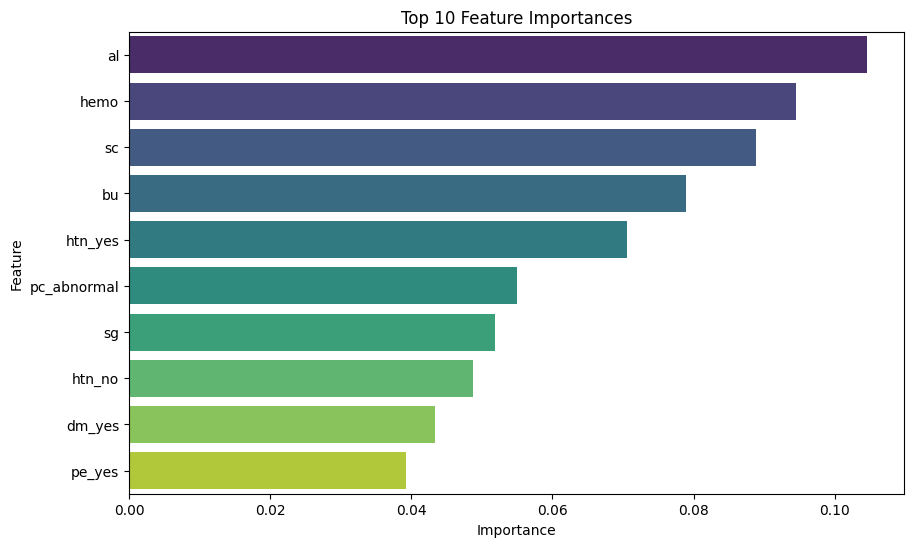

✅ Pipeline saved as kidney_disease_pipeline.pkl


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import cloudpickle

# -------------------------------
# 1. Load and clean dataset
# -------------------------------
df = pd.read_csv("kidney_disease.csv")
df = df.dropna(axis=1, how='all').dropna()
df['classification'] = df['classification'].str.strip().replace({'ckd': 1, 'notckd': 0})

# Drop 'id' column if present
if 'id' in df.columns:
    df = df.drop(columns=['id'])

X = df.drop(columns=['classification'])
y = df['classification'].astype(int)

# Identify categorical and numerical columns
cat_features = X.select_dtypes(include=['object']).columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# -------------------------------
# 2. Temporary RF to select top 10 features
# -------------------------------
preprocessor_all = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

temp_pipeline = ImbPipeline([
    ('preprocessor', preprocessor_all),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

temp_pipeline.fit(X, y)

# Extract feature importances
rf_model = temp_pipeline.named_steps['classifier']
ohe = temp_pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_names = ohe.get_feature_names_out(cat_features)
all_features = np.concatenate([num_features, cat_names])
importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Select top 10 encoded features and map to raw features
top_10_encoded = feature_importance_df.head(10)['Feature'].tolist()
selected_num = [f for f in num_features if f in top_10_encoded]
selected_cat = [f for f in cat_features if any(f in t for t in top_10_encoded)]
selected_features = list(set(selected_num + selected_cat))

print("Top 10 Raw Features (without 'id'):", selected_features)

# -------------------------------
# 3. Split data using only top 10 features
# -------------------------------
X_top = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_top, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# 4. Final pipeline with top features
# -------------------------------
preprocessor_top = ColumnTransformer([
    ('num', StandardScaler(), [f for f in selected_features if f in num_features]),
    ('cat', OneHotEncoder(handle_unknown='ignore'), [f for f in selected_features if f in cat_features])
])

pipeline_top = ImbPipeline([
    ('preprocessor', preprocessor_top),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

pipeline_top.fit(X_train, y_train)

# -------------------------------
# 5. Evaluate
# -------------------------------
y_pred = pipeline_top.predict(X_test)
y_proba = pipeline_top.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# -------------------------------
# 6. Plot top 10 feature importances
# -------------------------------
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10), palette="viridis")
plt.title("Top 10 Feature Importances")
plt.show()

# -------------------------------
# 7. Save pipeline
# -------------------------------
with open("kidney_disease_pipeline.pkl", "wb") as f:
    cloudpickle.dump(pipeline_top, f)

print("✅ Pipeline saved as kidney_disease_pipeline.pkl")
